In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import warnings

warnings.filterwarnings("ignore")

### Инициализируем датафреймы и выведем первичную информацию по каждой таблице

In [2]:
# Загрузим данные по датафрейму train
train = pd.read_csv('./data/train.csv')

- row_id: (int64) Код идентификатора строки.

- timestamp: (int64) Время в миллисекундах между взаимодействием пользователя и завершением первого события от этого пользователя.

- user_id: (int32) Код идентификатора пользователя.

- content_id: (int16) Код идентификатора взаимодействия пользователя.

- content_type_id: (int8) 0, если событие было вопросом, адресованным пользователю, 1, если событием было то, что пользователь смотрел лекцию.

- task_container_id: (int16) Код идентификатора блока вопросов или лекций. Например, пользователь может увидеть три вопроса подряд перед тем, как увидеть объяснения к любому из них. Эти три будут иметь общий task_container_id.

- user_answer: (int8) Ответ пользователя на вопрос, если таковой имеется. Считать -1 как пустое значение, для лекций.

- answered_correctly: (int8) Если пользователь ответил правильно. Считать -1 как пустое значение, для лекций.

- prior_question_elapsed_time: (float32) Среднее время в миллисекундах, которое потребовалось пользователю для ответа на каждый вопрос в предыдущем наборе вопросов, игнорируя любые лекции между ними. Значение равно нулю для первой группы вопросов или лекции пользователя. Обратите внимание, что время является средним временем, которое потребовалось пользователю для решения каждого вопроса в предыдущем наборе.

- prior_question_had_explanation: (bool) Был ли у пользователя просмотр объяснений и правильных ответов после ответа на предыдущий набор вопросов, игнорируя любые лекции между ними. Значение применяется ко всему набору вопросов и равно нулю для первой группы вопросов или лекции пользователя. Обычно первые несколько вопросов, которые видит пользователь, являются частью диагностического теста для ознакомления, где он не получает никакой обратной связи.

In [3]:
# Выведем по 5 первых и последних записей
display(train.head(),train.tail())

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
101230327,101230327,428564420,2147482888,3586,0,22,0,1,18000.0,True
101230328,101230328,428585000,2147482888,6341,0,23,3,1,14000.0,True
101230329,101230329,428613475,2147482888,4212,0,24,3,1,14000.0,True
101230330,101230330,428649406,2147482888,6343,0,25,1,0,22000.0,True
101230331,101230331,428692118,2147482888,7995,0,26,3,1,29000.0,True


In [4]:
train.shape

(101230332, 10)

In [5]:
# Уменьшим датасет для работы
X = train.drop(columns=["answered_correctly"], axis=1)
y = train["answered_correctly"]

In [6]:
# Используем трейн тест разбивку для сохранения пропорций таргета и приближения 
# к базовому датасету
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.3, stratify=y)

In [7]:
# Рекомбинируем датасет содержащий 30% выборку
train_data = pd.concat([X_train, y_train], axis=1)

In [8]:
# Посмотрим на полученный результат
train_data.shape

(30369099, 10)

In [9]:
# Создадим копию для манипуляций
train = train_data.copy()

In [10]:
# Проверка дубликатов
train[train.duplicated()]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly


> дубликатов нет

In [11]:
# Удалим неинформативные стообцы являющиеся индексами строк
train_processed = train.drop(["row_id"], axis=1)

----

In [12]:
# Загрузим данные по датафрейму lectures
lectures = pd.read_csv('./data/lectures.csv')

In [13]:
# Выведем по 5 первых и последних записей
display(lectures.head(),lectures.tail())

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


,lecture_id,tag,part,type_of
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept
417,32736,82,3,concept


- lecture_id: внешний ключ для столбца train/test content_id, когда тип контента – лекция (1).

- part: код верхнего уровня категории для лекции.

- tag: один код тега для лекции. Значение тегов предоставляться не будет, но эти коды достаточны для группировки лекций вместе.

- type_of: краткое описание основной цели лекции.

In [14]:
# Дубликаты
lectures[lectures.duplicated()]

,lecture_id,tag,part,type_of


In [15]:
# Форма
lectures.shape

(418, 4)

---

In [16]:
# Загрузим данные по датафрейму questions
questions = pd.read_csv('./data/questions.csv')

In [17]:
# Выведем по 5 первых и последних записей
display(questions.head(),questions.tail())

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


,question_id,bundle_id,correct_answer,part,tags
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125
13522,13522,13522,3,5,55


- question_id: внешний ключ для столбца train/test content_id, когда тип контента – вопрос (0).

- bundle_id: код для вопросов, которые подаются вместе.

- correct_answer: ответ на вопрос. Его можно сравнить с колонной train user_answer, чтобы проверить, был ли прав пользователь.

- part: соответствующий раздел теста TOEIC.

- tags: один или несколько подробных кодов тегов для вопроса. Значение тегов предоставляться не будет, но эти коды достаточны для группировки вопросов вместе.

In [18]:
# Форма
questions.shape

(13523, 5)

In [19]:
# Дубликаты
questions[questions.duplicated()]

,question_id,bundle_id,correct_answer,part,tags


---

### Избавимся от нормализованности таблиц и объединим все в один датафрейм

In [20]:
# Вновь посмотрим на структуру основного фрейма и начнем мержить
train_processed.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly
87504595,1783785428,1861706184,1282,0,363,1,16000.0,True,0
45491898,9051400785,963368121,2847,0,4634,3,8000.0,True,1
70409096,117440,1497969775,8351,0,3,2,60000.0,False,0
24074099,47596194346,514694868,5262,0,96,1,37000.0,True,0
80026236,18509808841,1703582144,8783,0,6582,1,17000.0,True,1


In [21]:
# Сначала объединим train с lectures
data_lectures = pd.merge(
    left=train_processed, right=lectures, 
    left_on="content_id", right_on="lecture_id",
)

# Дропнем ключ так как он больше не нужен
data_lectures = data_lectures.drop(["lecture_id"], axis=1)

# Проверим результат
display(data_lectures.head())

print(data_lectures.shape)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,tag,part,type_of
0,8336041409,1638689100,8513,1,569,-1,NaN,False,-1,164,1,solving question
1,16151084716,173980154,21509,1,1677,-1,NaN,False,-1,66,5,solving question
2,14552479794,228713808,20804,1,1227,-1,NaN,False,-1,174,5,solving question
3,10617563543,815419412,335,1,1007,-1,NaN,False,-1,114,2,concept
4,91556438,129137151,26852,1,40,-1,NaN,False,-1,148,2,concept


(978221, 12)


In [22]:
# Теперь объединим data с questiones
data_question = pd.merge(
    left=train_processed, right=questions, 
    left_on="content_id", right_on="question_id",
)

# Дропнем ключ так как он больше не нужен
data_question = data_question.drop(["question_id"], axis=1)

# Проверим результат
display(data_question.head())
print(data_question.shape)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags
0,1783785428,1861706184,1282,0,363,1,16000.0,True,0,1282,0,2,2 20 38 92
1,9051400785,963368121,2847,0,4634,3,8000.0,True,1,2845,3,4,82 144 81
2,117440,1497969775,8351,0,3,2,60000.0,False,0,8351,0,5,73
3,47596194346,514694868,5262,0,96,1,37000.0,True,0,5262,0,5,65
4,18509808841,1703582144,8783,0,6582,1,17000.0,True,1,8783,1,5,45


(30011386, 13)


In [23]:
# Создадим объединенный денормализованный датасет processed_data
processed_data = pd.concat([data_question, data_lectures])
display(processed_data)
print(processed_data.shape)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
0,1783785428,1861706184,1282,0,363,1,16000.0,True,0,1282.0,0.0,2,2 20 38 92,NaN,NaN
1,9051400785,963368121,2847,0,4634,3,8000.0,True,1,2845.0,3.0,4,82 144 81,NaN,NaN
2,117440,1497969775,8351,0,3,2,60000.0,False,0,8351.0,0.0,5,73,NaN,NaN
3,47596194346,514694868,5262,0,96,1,37000.0,True,0,5262.0,0.0,5,65,NaN,NaN
4,18509808841,1703582144,8783,0,6582,1,17000.0,True,1,8783.0,1.0,5,45,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978216,4083712404,1509236506,13660,1,682,-1,NaN,False,-1,NaN,NaN,5,NaN,125.0,concept
978217,2968165943,426040892,5120,0,85,0,15000.0,True,1,NaN,NaN,5,NaN,177.0,solving question
978218,2259671554,747266821,24985,1,438,-1,NaN,False,-1,NaN,NaN,5,NaN,44.0,concept
978219,698682,1041593843,10688,0,20,0,21000.0,True,1,NaN,NaN,7,NaN,39.0,concept


(30989607, 15)


In [24]:
# Сохранение в CSV для бэкапа предыдущих шагов
with open("./data/processed_data.csv", "w", encoding="utf-8") as file:
    processed_data.to_csv(file, index=False)

----


In [3]:
# Очистив буфер реинициализируем датафрейм
processed_data = pd.read_csv("./data/processed_data.csv")

In [4]:
# Проверим как оно получилось
display(processed_data.head(), processed_data.tail())
print(processed_data.shape)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
0,1783785428,1861706184,1282,0,363,1,16000.0,True,0,1282.0,0.0,2,2 20 38 92,NaN,NaN
1,9051400785,963368121,2847,0,4634,3,8000.0,True,1,2845.0,3.0,4,82 144 81,NaN,NaN
2,117440,1497969775,8351,0,3,2,60000.0,False,0,8351.0,0.0,5,73,NaN,NaN
3,47596194346,514694868,5262,0,96,1,37000.0,True,0,5262.0,0.0,5,65,NaN,NaN
4,18509808841,1703582144,8783,0,6582,1,17000.0,True,1,8783.0,1.0,5,45,NaN,NaN


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
30989602,4083712404,1509236506,13660,1,682,-1,NaN,False,-1,NaN,NaN,5,NaN,125.0,concept
30989603,2968165943,426040892,5120,0,85,0,15000.0,True,1,NaN,NaN,5,NaN,177.0,solving question
30989604,2259671554,747266821,24985,1,438,-1,NaN,False,-1,NaN,NaN,5,NaN,44.0,concept
30989605,698682,1041593843,10688,0,20,0,21000.0,True,1,NaN,NaN,7,NaN,39.0,concept
30989606,1021527780,931563762,24402,1,703,-1,NaN,False,-1,NaN,NaN,1,NaN,149.0,concept


(30989607, 15)


In [5]:
# Переведем временные фичи к минутам для простоты анализа
processed_data["timestamp"] = processed_data["timestamp"] / 1000 / 60

processed_data["prior_question_elapsed_time"] = (
    processed_data["prior_question_elapsed_time"] / 1000 / 60
)

In [6]:
# Заполним чассть пропусков после мержа таблиц, лэйблами, где пропущенным значениям будет присваиваться категория
tags = LabelEncoder()
processed_data["tags"] = tags.fit_transform(processed_data["tags"])

tag = LabelEncoder()
processed_data["tag"] = tag.fit_transform(processed_data["tag"])

type_of = LabelEncoder()
processed_data["type_of"] = type_of.fit_transform(processed_data["type_of"])

bundle_id = LabelEncoder()
processed_data["bundle_id"] = bundle_id.fit_transform(processed_data["bundle_id"])

# Сразу заполним пропуски
processed_data["prior_question_elapsed_time"].fillna(0, inplace=True)
processed_data["prior_question_had_explanation"].fillna(False, inplace=True)

processed_data["correct_answer"].fillna(-1, inplace=True)


display(processed_data.head(), processed_data.tail())

# Проверка наличия пропущенных значений
print(processed_data.isnull().sum())

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
0,29729.757133,1861706184,1282,0,363,1,0.266667,True,0,1282,0.0,2,906,151,4
1,150856.679750,963368121,2847,0,4634,3,0.133333,True,1,1882,3.0,4,1256,151,4
2,1.957333,1497969775,8351,0,3,2,1.000000,False,0,5826,0.0,5,1109,151,4
3,793269.905767,514694868,5262,0,96,1,0.616667,True,0,3830,0.0,5,1076,151,4
4,308496.814017,1703582144,8783,0,6582,1,0.283333,True,1,6258,1.0,5,971,151,4


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
30989602,68061.873400,1509236506,13660,1,682,-1,0.00,False,-1,9763,-1.0,5,1519,97,0
30989603,49469.432383,426040892,5120,0,85,0,0.25,True,1,9763,-1.0,5,1519,142,2
30989604,37661.192567,747266821,24985,1,438,-1,0.00,False,-1,9763,-1.0,5,1519,34,0
30989605,11.644700,1041593843,10688,0,20,0,0.35,True,1,9763,-1.0,7,1519,30,0
30989606,17025.463000,931563762,24402,1,703,-1,0.00,False,-1,9763,-1.0,1,1519,118,0


timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
prior_question_elapsed_time       0
prior_question_had_explanation    0
answered_correctly                0
bundle_id                         0
correct_answer                    0
part                              0
tags                              0
tag                               0
type_of                           0
dtype: int64


In [7]:
# Пщсмотрим типы данных и перекодируем категориальные признаки
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30989607 entries, 0 to 30989606
Data columns (total 15 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       float64
 1   user_id                         int64  
 2   content_id                      int64  
 3   content_type_id                 int64  
 4   task_container_id               int64  
 5   user_answer                     int64  
 6   prior_question_elapsed_time     float64
 7   prior_question_had_explanation  bool   
 8   answered_correctly              int64  
 9   bundle_id                       int64  
 10  correct_answer                  float64
 11  part                            int64  
 12  tags                            int64  
 13  tag                             int64  
 14  type_of                         int64  
dtypes: bool(1), float64(3), int64(11)
memory usage: 3.3 GB


- tags - представляют собой закодированный теги вопросов в формате строки с разделителем пробел (возможно представляет смысл использовать one hot encoding).
- type_of - представляет собой краткое описание основной цели лекции (имеет смысл проверить количество категорий и использовать label encoder)

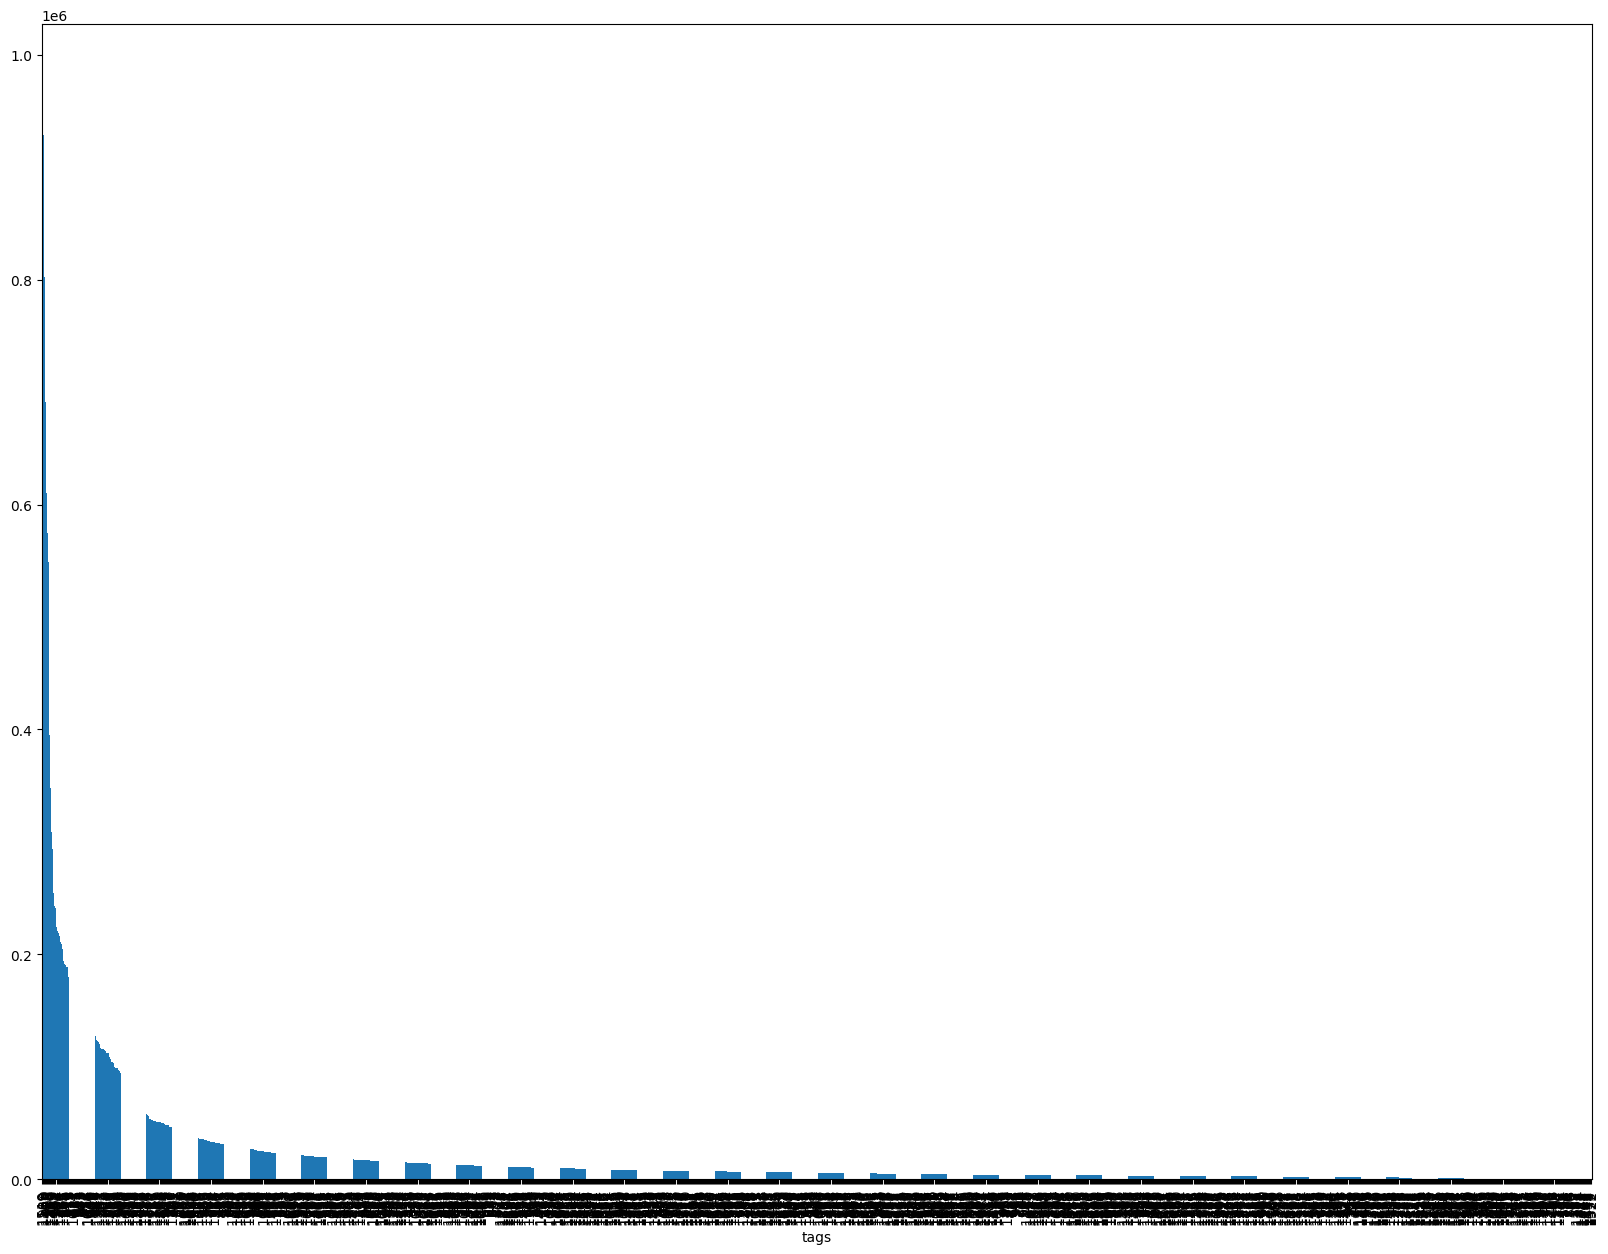

Количество уникальных тегов 1520


In [8]:
# Первый взгляд на распределение tags
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
processed_data["tags"].value_counts().plot(kind="bar")
plt.show()
print(f"Количество уникальных тегов {processed_data['tags'].nunique()}")

Заметно разбиение тегов по батчам примерно на 30 групп

In [9]:
# Создание новой колонки с перекодированными значениями разбивая по бинам
processed_data["tags_group"] = pd.cut(
    processed_data["tags"], bins=range(0, 1521, 50), labels=range(30)
)


In [10]:
# Удалим тэги
processed_data = processed_data.drop(["tags"], axis=1)

In [11]:
processed_data.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tag,type_of,tags_group
0,29729.757133,1861706184,1282,0,363,1,0.266667,True,0,1282,0.0,2,151,4,18
1,150856.679750,963368121,2847,0,4634,3,0.133333,True,1,1882,3.0,4,151,4,25
2,1.957333,1497969775,8351,0,3,2,1.000000,False,0,5826,0.0,5,151,4,22
3,793269.905767,514694868,5262,0,96,1,0.616667,True,0,3830,0.0,5,151,4,21
4,308496.814017,1703582144,8783,0,6582,1,0.283333,True,1,6258,1.0,5,151,4,19


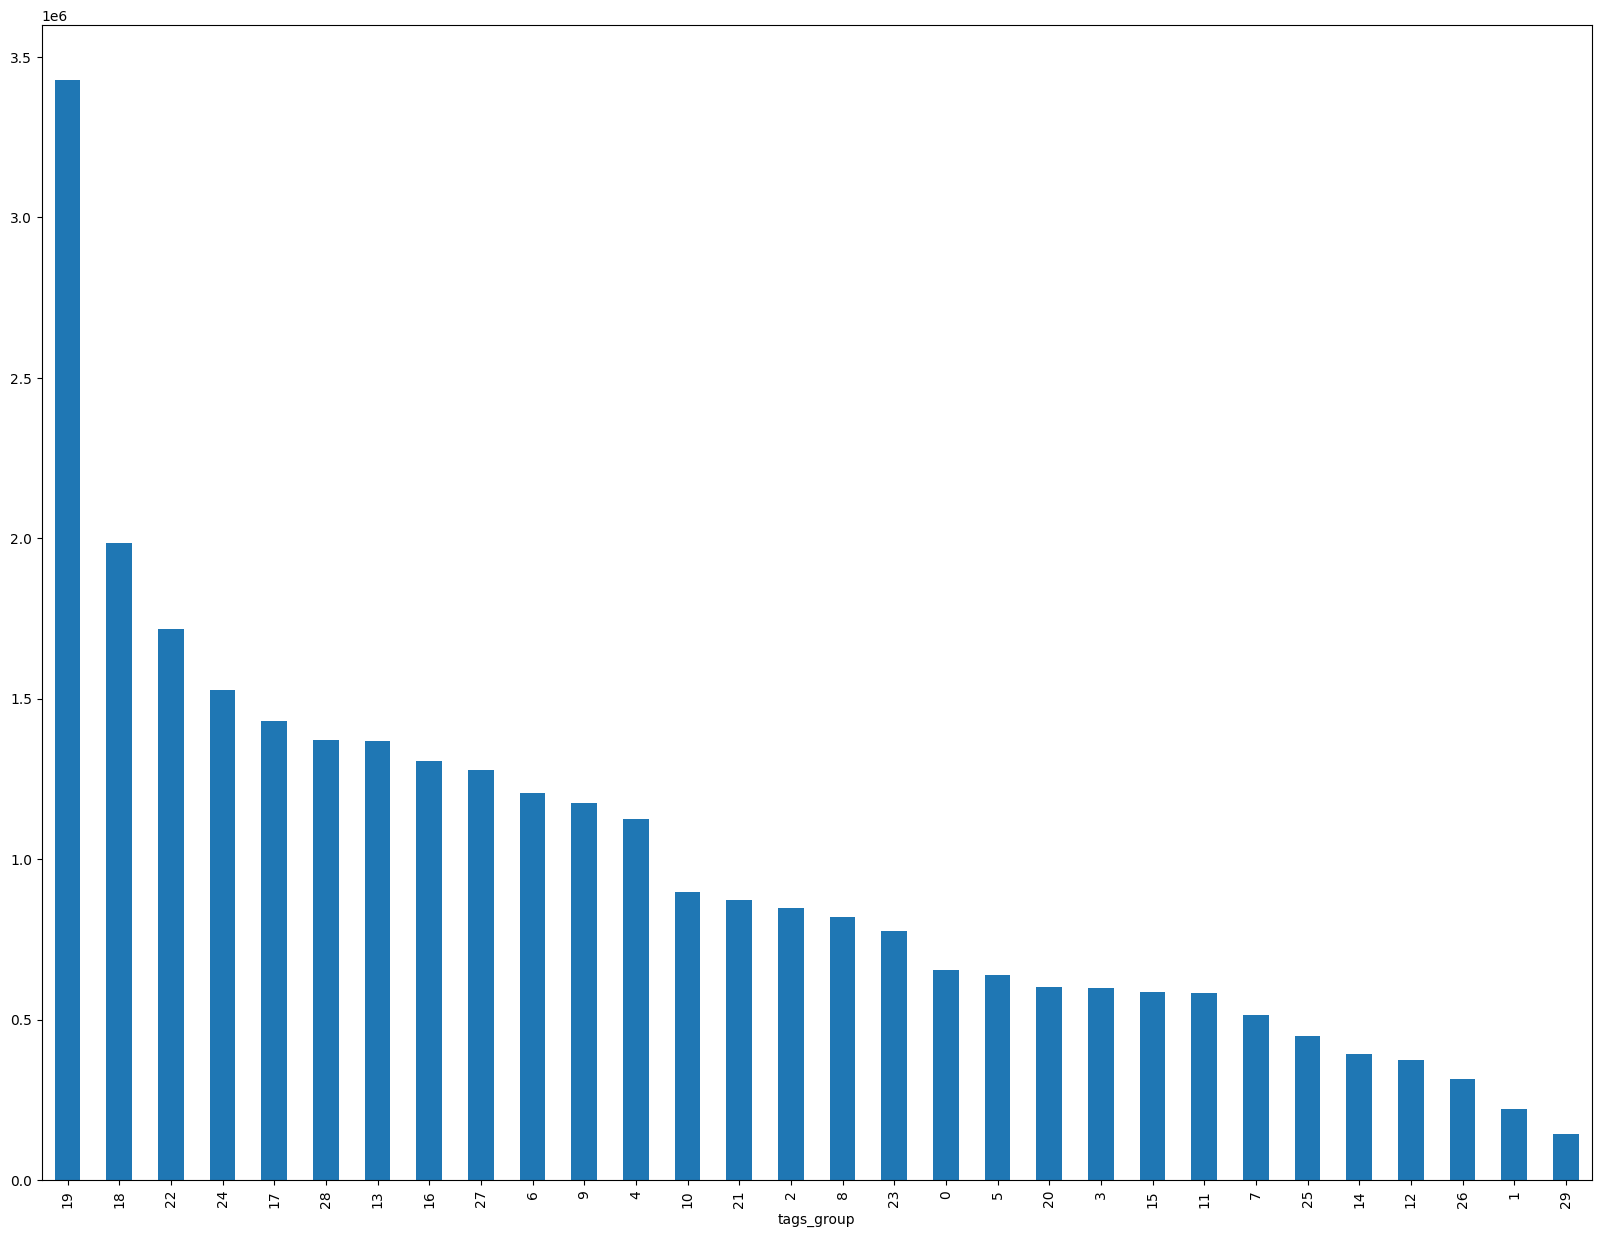

Количество уникальных тегов 30


In [12]:
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
processed_data["tags_group"].value_counts().plot(kind="bar")
plt.show()
print(f"Количество уникальных тегов {processed_data['tags_group'].nunique()}")

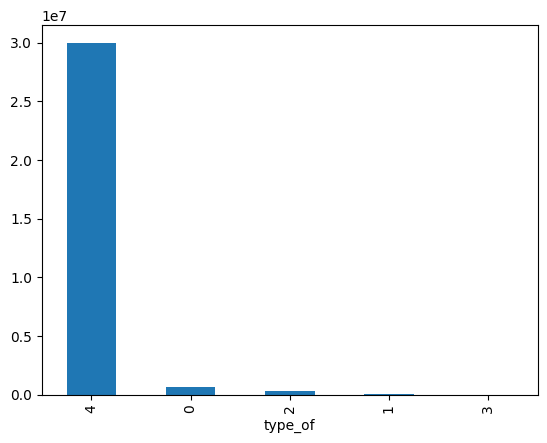

In [13]:
# Поработаем над type_of (тип лекции)
processed_data["type_of"].value_counts().plot(kind="bar")
plt.show()

In [14]:
# Посмотрим сколько уникальных пользователей
print(f"Количество уникальных пользователей: \
{processed_data['user_id'].nunique()}")

Количество уникальных пользователей: 393020


Количество типов взаимодействия: 2


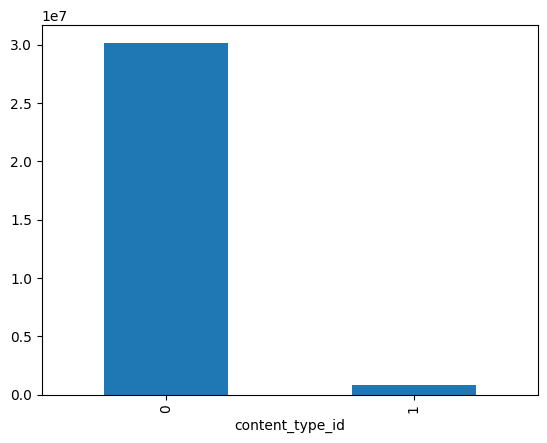

In [15]:
# Посмотрим сколько уникальных типов взаимодействия
processed_data["content_type_id"].value_counts().plot(kind="bar")
print(f"Количество типов взаимодействия: \
{processed_data['content_type_id'].nunique()}")

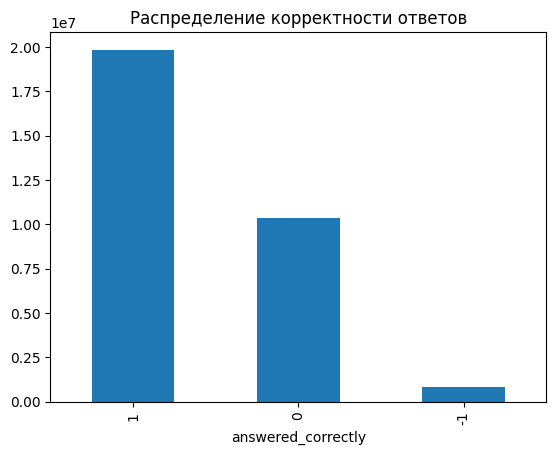

In [16]:
# Посмотрим на распределение значений целевой переменной
processed_data["answered_correctly"].value_counts().plot(kind="bar")
plt.title("Распределение корректности ответов")
plt.show()

Нашим таргетом для последующего моделирования бинарной классификации служат метки 1 и 0, выдвинул предположение, что нет смысла предсказывать отсутствие ответа на лекционном материале

In [17]:
# Посмотрим количество строк соответствующих лекциям
processed_data[processed_data["answered_correctly"] == -1].shape

(817705, 15)

Как видно можно облегчить датасет

In [43]:
# Отфильтровываем их
data = processed_data[processed_data["answered_correctly"] != -1]

In [44]:
# Смотрим форму
data.shape

(30171902, 15)

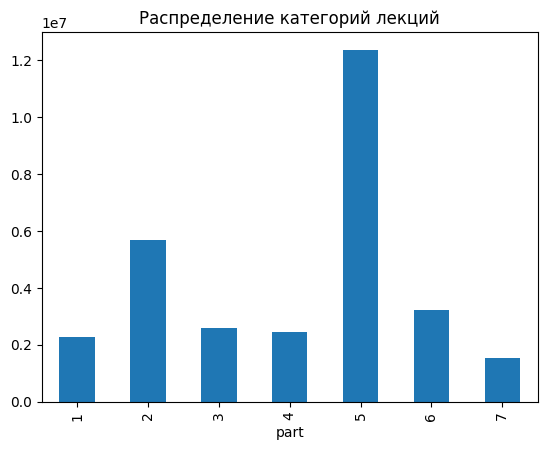

In [45]:
# Изучение распределения значений категориальных переменных
data["part"].value_counts().sort_index().plot(kind="bar")
plt.title("Распределение категорий лекций")
plt.show()

In [46]:
# Введем функцию расчета процента правильных ответов относительно фита
def calculate_percent_correct(field, data = processed_data):
    correct_data = (
        data[data.answered_correctly != -1]
        .groupby([field, "answered_correctly"])
        .size()
        .unstack()
    )
    correct_data["Percent_correct"] = round(
        correct_data[1] / (correct_data[0] + correct_data[1]), 2
    )
    correct_data.sort_values(by="Percent_correct", ascending=False, inplace=True)
    return correct_data["Percent_correct"]

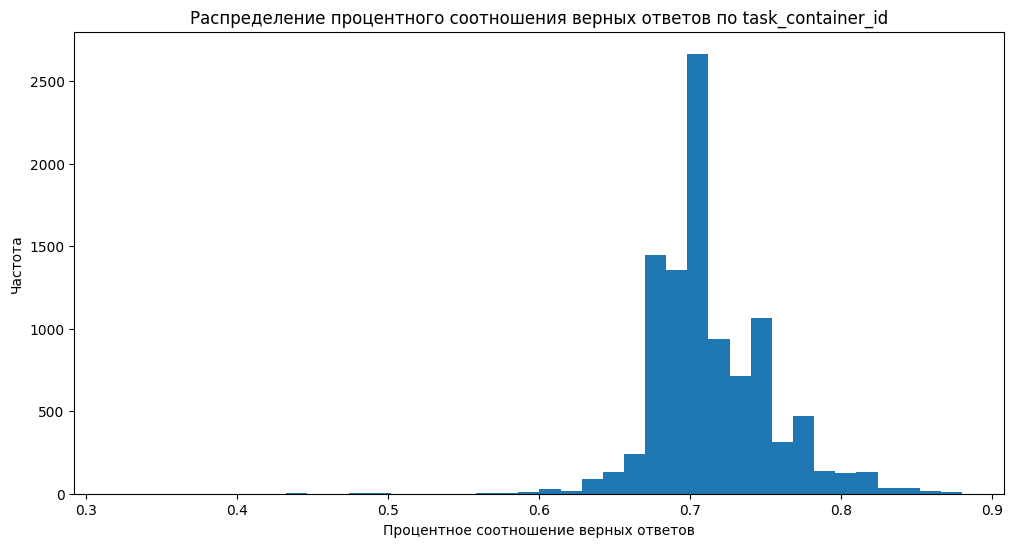

In [47]:
# Посмотрим на распределение процентного соотношения корректных ответов в контексте фита
task_id_correct = calculate_percent_correct("task_container_id")

fig, ax = plt.subplots(figsize=(12, 6))
task_id_correct.plot.hist(bins=40, ax=ax)
ax.set_title(
    "Распределение процентного соотношения верных ответов по task_container_id"
)
ax.set_xlabel("Процентное соотношение верных ответов")
ax.set_ylabel("Частота")
plt.show()

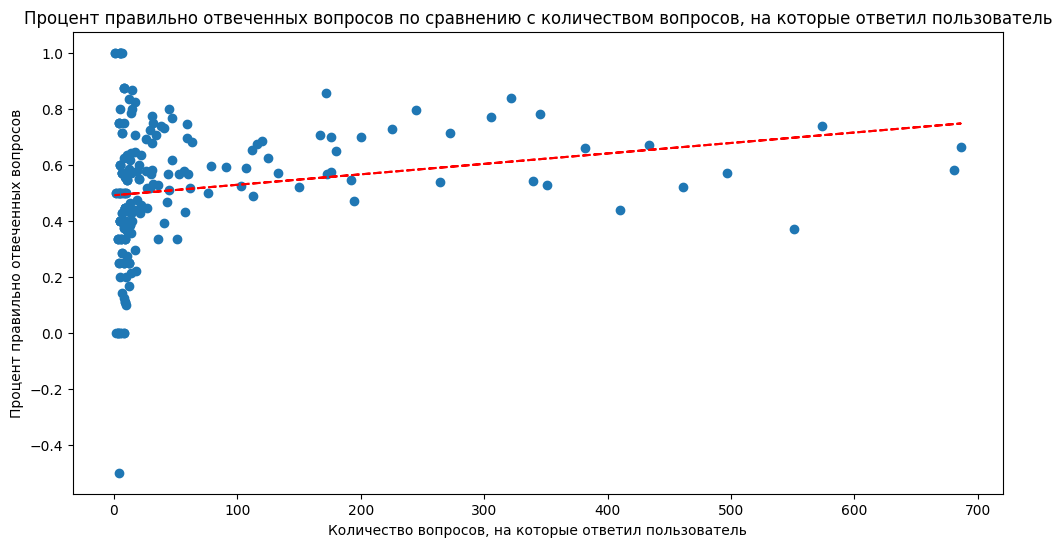

In [48]:
# Посмотрим скаттер с трендом
user_percent = processed_data.groupby("user_id")["answered_correctly"].agg(
    Mean="mean", Answers="count"
)

user_percent = user_percent.query("Answers <= 1000").sample(n=200, random_state=1)

fig = plt.figure(figsize=(12, 6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker="o")
plt.title(
    "Процент правильно отвеченных вопросов по сравнению с количеством вопросов, на которые ответил пользователь"
)
plt.xticks(rotation=0)
plt.xlabel("Количество вопросов, на которые ответил пользователь")
plt.ylabel("Процент правильно отвеченных вопросов")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

plt.show()

В целом можно отметить положительную связь между колличеством правильных ответов и общим колличеством ответов данных пользователем

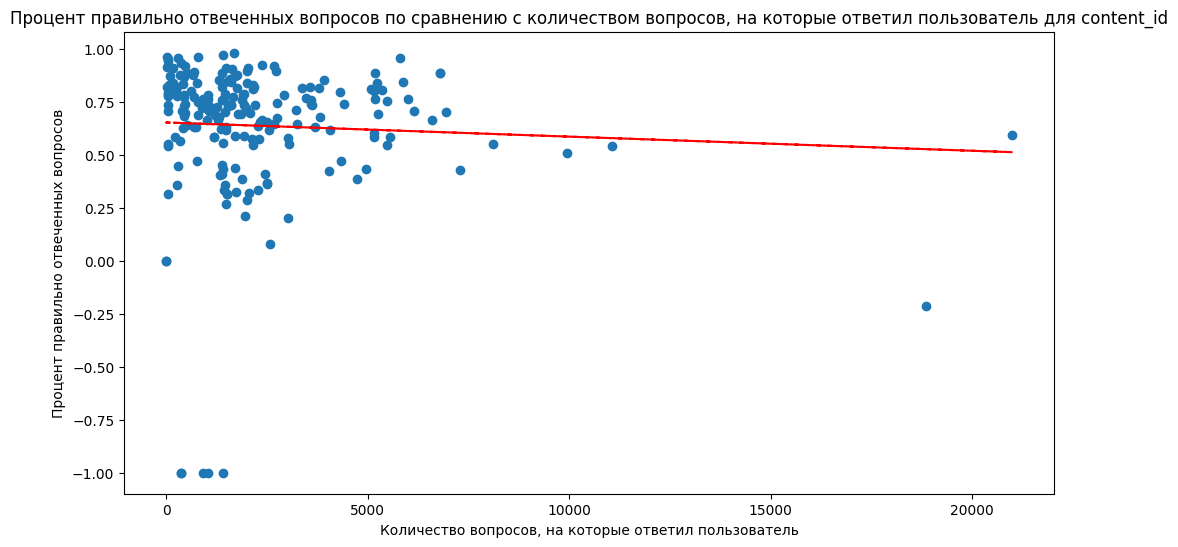

In [49]:
# То же самое для другого фита
content_percent = processed_data.groupby("content_id")["answered_correctly"].agg(
    Mean="mean", Answers="count"
)

content_percent = content_percent.query("Answers <= 25000").sample(
    n=200, random_state=1, replace=True
)

fig = plt.figure(figsize=(12, 6))
x = content_percent.Answers
y = content_percent.Mean
plt.scatter(x, y, marker="o")
plt.title(
    "Процент правильно отвеченных вопросов по сравнению с количеством вопросов, на которые ответил пользователь для content_id"
)
plt.xticks(rotation=0)
plt.xlabel("Количество вопросов, на которые ответил пользователь")
plt.ylabel("Процент правильно отвеченных вопросов")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

plt.show()

Обратная связь с content_id, что может говорить о неравномерном распределении сложности

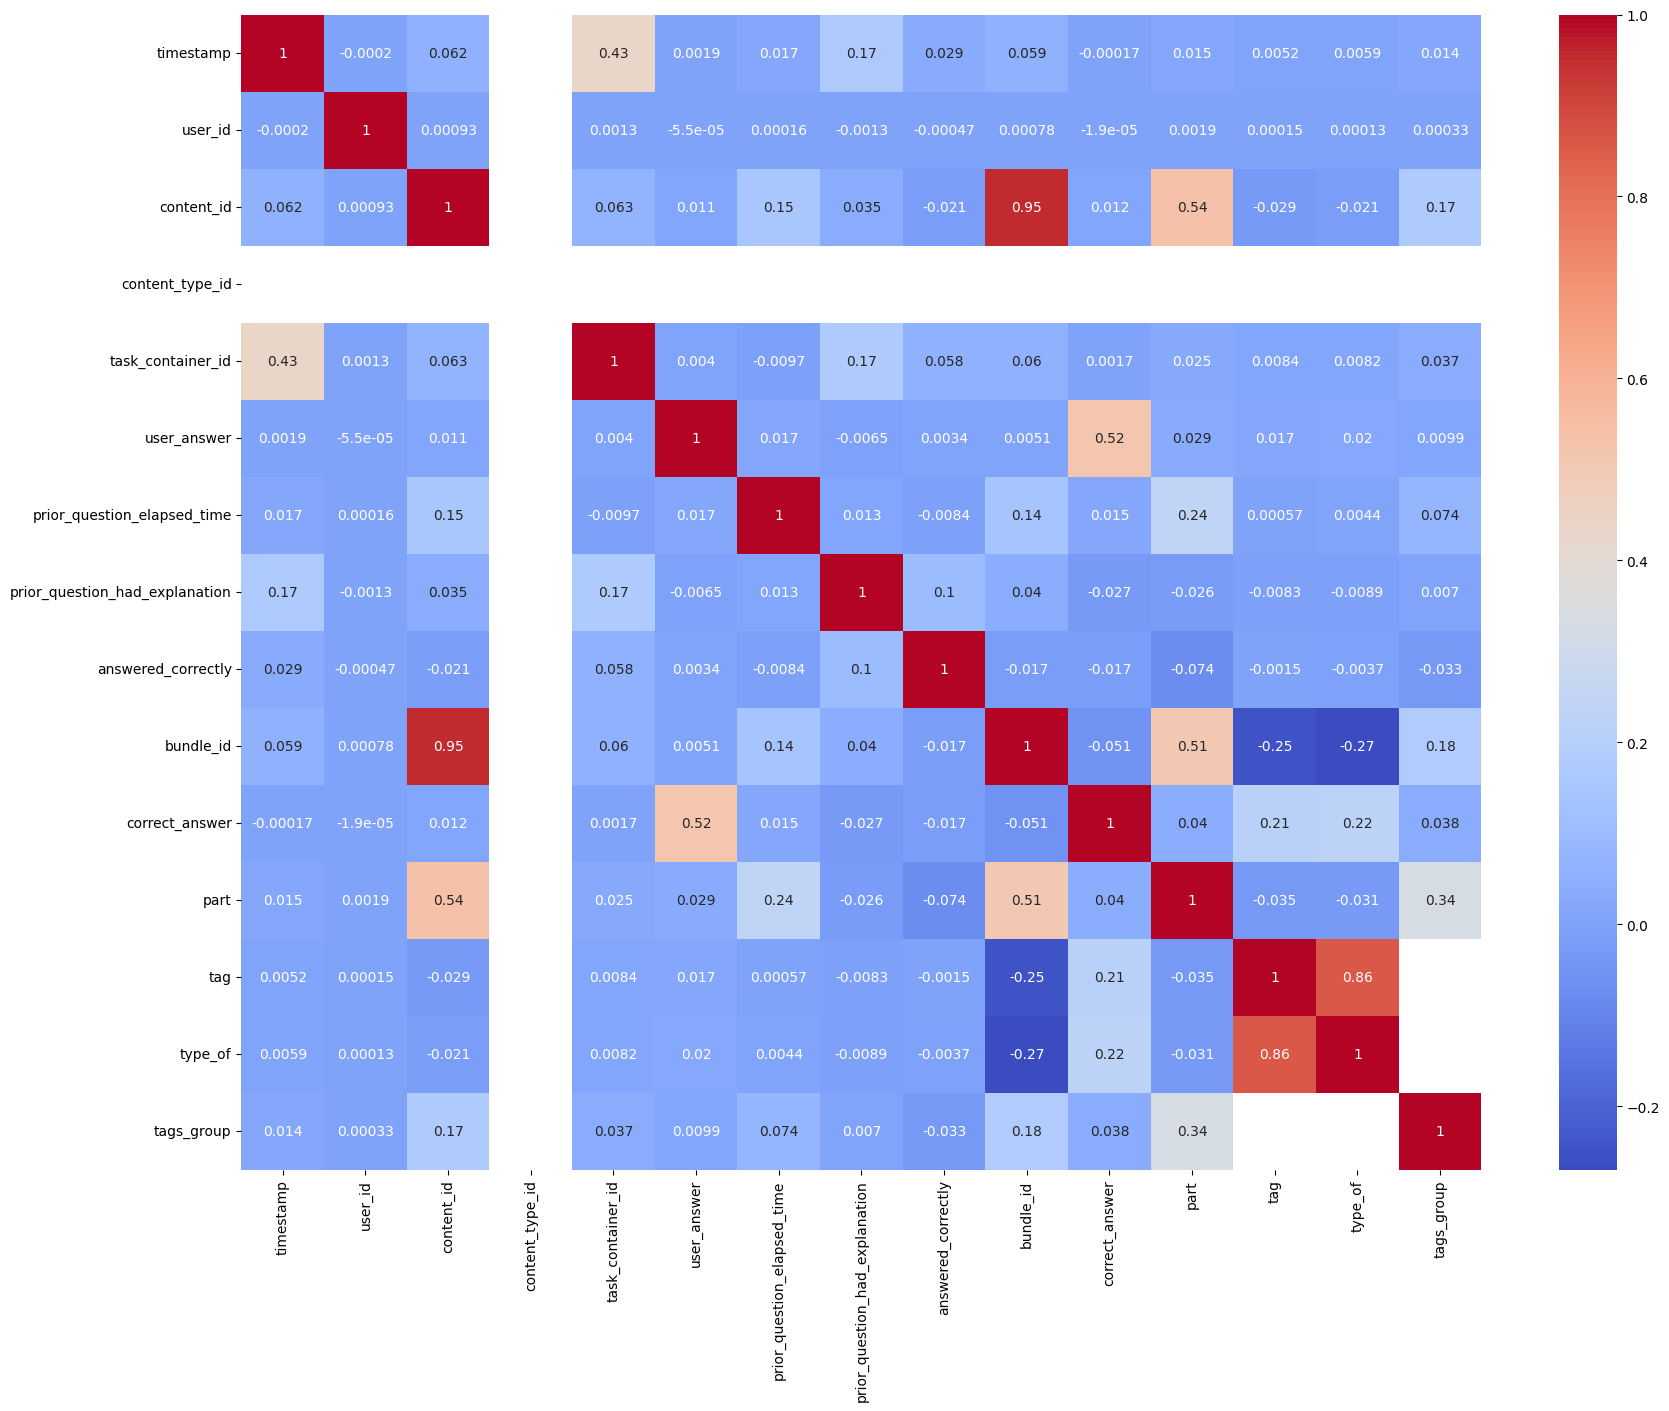

In [50]:
# Поиск корреляций между переменными и удаление мультиколлинеарности
correlation_matrix = data.corr()
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes)
plt.show()

Мультиколлинеарность:
- Видна сильная корреляция между bundle_id и content_id, влияние на таргет (answered corretly) меньше у bundle_id, следовательно убираем

- Видна сильная корреляция между type_of и tag/content_type_id, влияние на таргет (answered corretly) меньше у tag, но за счет того что есть вероятность мультиколлинеарности с content_type_id, убрал type_of

Низкое влияние:
- user_id



In [51]:
# Скинем колонки указанные на предыдущем этапе
data.drop(
    columns=[
        "bundle_id",
        "user_id",
        "type_of"
    ], inplace=True
)

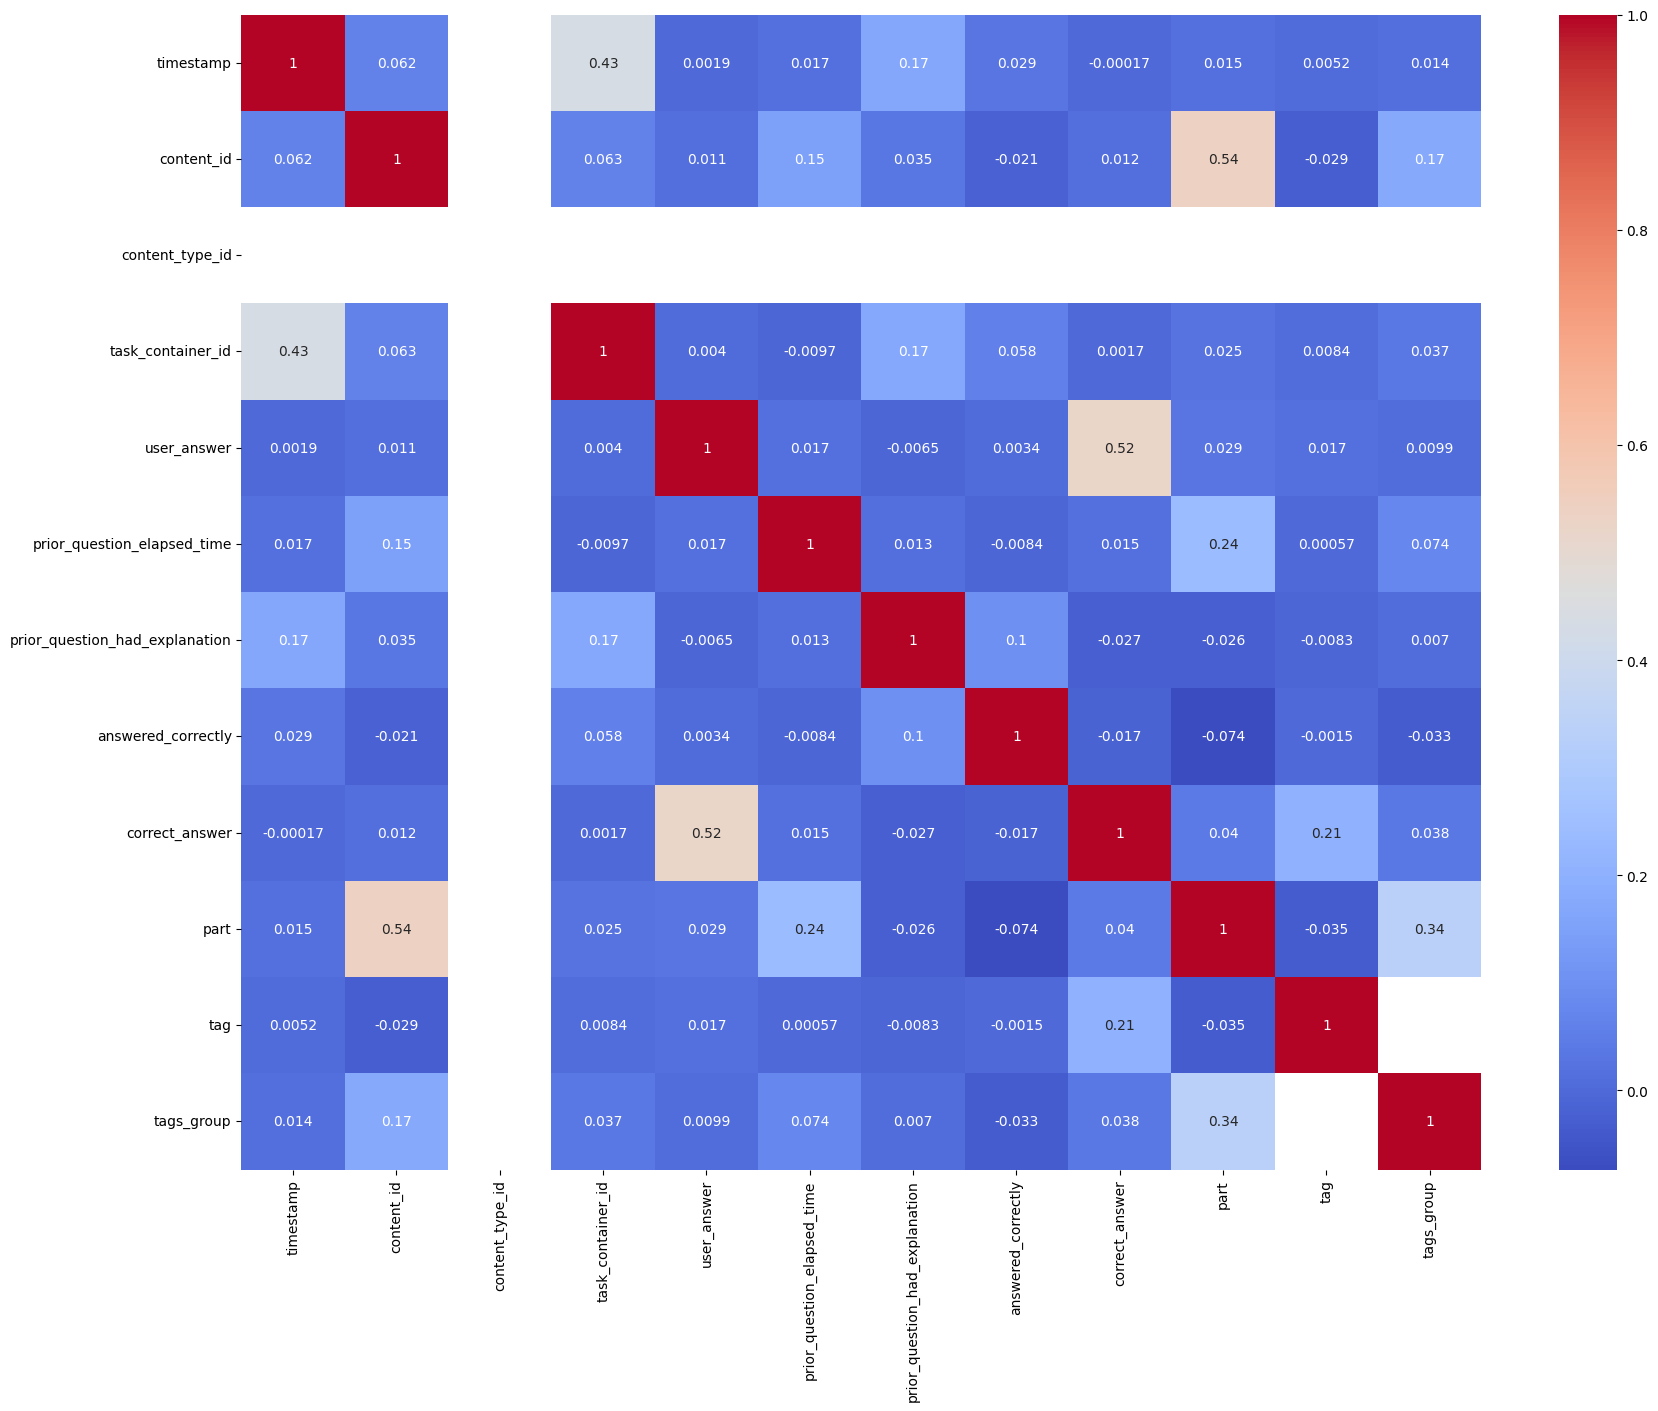

In [52]:
# Посмотрим на матрицу еще раз стоит отметить наличие констант
correlation_matrix = data.corr()
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes)
plt.show()

----

### Теперь, после поверхностного исследования датафрейма, и первичной очистки, углубимся в те фичи, которые остались, в каждую по отдельности, даже если до этого рассматривали.

---

#### content_type_id

Количество типов взаимодействия: 1


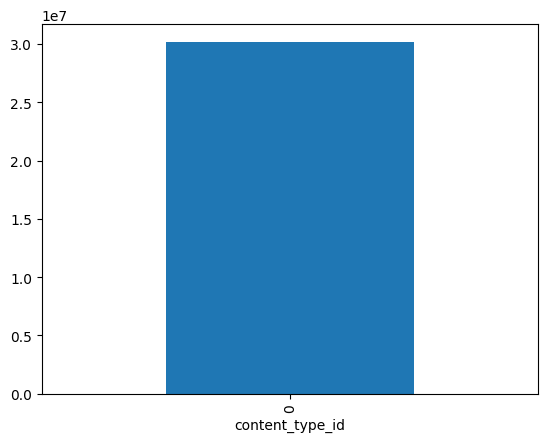

In [53]:
# Посмотрим сколько уникальных типов взаимодействия
data["content_type_id"].value_counts().plot(kind="bar")
print(f"Количество типов взаимодействия: \
{data['content_type_id'].nunique()}")

Остались только тесты, следовательно колонка констант подлежит удалению

In [54]:
# Скидываем колонку
data = data.drop(columns=["content_type_id"], axis=1)

---

#### content_id

Количество типов взаимодействия: 13516


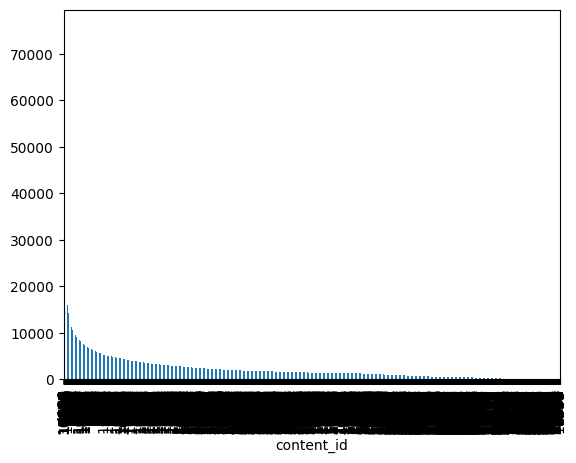

In [55]:
# Посмотрим сколько уникальных типов взаимодействия
data["content_id"].value_counts().plot(kind="bar")
print(f"Количество типов взаимодействия: \
{data['content_id'].nunique()}")

Квантированная информация, в условиях объема датасета, количество уникальных значений разумно, но в суловиях не существенного влияния на таргет, при возможном ухудшении производительности кандидат на удаление, либо же кодирование, но так как id-шники сложно разбить по пороговому значению без нарушения логики, я склоняюсь к удалению

----
#### timestamp

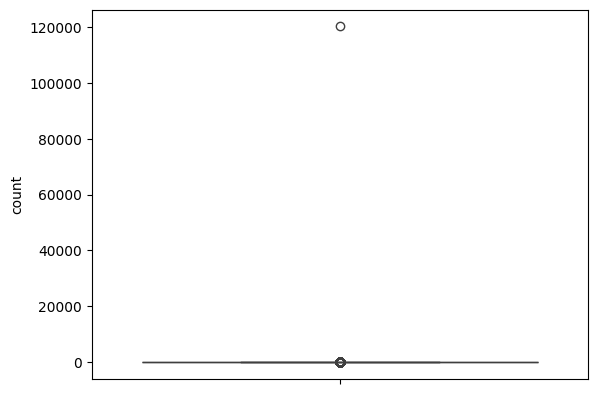

In [56]:
# Посмотри на boxplot временного взаимодействия в попытке найти выбросы
sns.boxplot(data["timestamp"].value_counts())
plt.show()

Выявлены потенциальные выбросы, либо же аномалии, которые могут повлиять на конечную метрику модели, на данный момент приведем признак к логарифмическому масштабу

In [57]:
data["timestamp"] = np.log(data["timestamp"]+1) # чтобы бесконечеость не получить
# И посмотрим на статистики
display(data["timestamp"].describe())


count    3.017190e+07
mean     9.925083e+00
std      3.082577e+00
min      0.000000e+00
25%      9.065057e+00
50%      1.070214e+01
75%      1.201540e+01
max      1.419196e+01
Name: timestamp, dtype: float64

-----
#### task_container_id

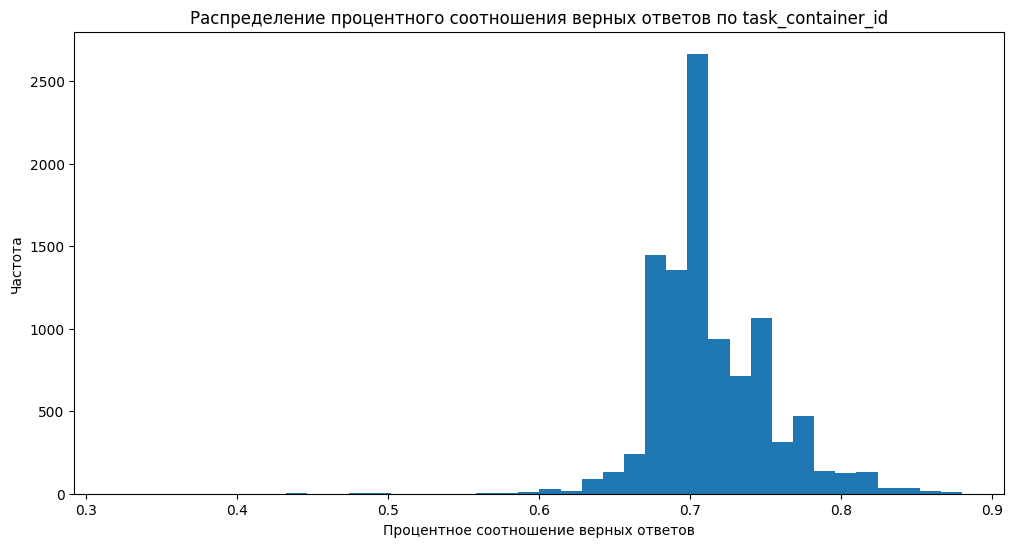

In [58]:
# Вновь посмотрим на task_container_id
task_id_correct = calculate_percent_correct("task_container_id")

fig, ax = plt.subplots(figsize=(12, 6))
task_id_correct.plot.hist(bins=40, ax=ax)
ax.set_title(
    "Распределение процентного соотношения верных ответов по task_container_id"
)
ax.set_xlabel("Процентное соотношение верных ответов")
ax.set_ylabel("Частота")
plt.show()

Распределение близко к нормальному

----
#### prior_question_had_explanation

prior_question_had_explanation
False     2902969
True     27268933
Name: (answered_correctly, count), dtype: int64


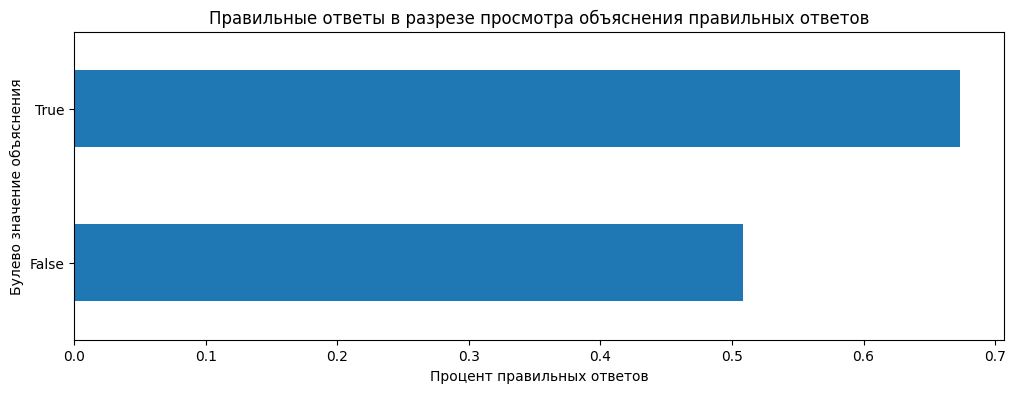

In [59]:
# Посмотрим на prior_question_had_explanation
pq = data.groupby(["prior_question_had_explanation"], dropna=False).agg(
    {"answered_correctly": ["mean", "count"]}
)

print(pq.iloc[:, 1])
pq = pq.iloc[:, 0]

fig = plt.figure(figsize=(12, 4))
pq.plot.barh()

plt.title("Правильные ответы в разрезе просмотра объяснения правильных ответов")
plt.xlabel("Процент правильных ответов")
plt.ylabel("Булево значение объяснения")
plt.xticks(rotation=0)
plt.show()

Довольно очевидный факт того, что при предварительном объяснении процент правильных ответов увеличивается

----
#### answered_correctly

In [60]:
# Составим матрицу статистик
pq_elapse = data.groupby(["answered_correctly"]).agg(
    {"answered_correctly": ["count"], "prior_question_elapsed_time": ["mean"]}
)
display(pq_elapse)

,answered_correctly,prior_question_elapsed_time
,count,mean
answered_correctly,,
0,10336224,0.425861
1,19835678,0.419992


В среднем показатель затраченного времени на ответ не значительно влияет на результат

----
#### user_answer и correct_answer
Есть подозрение, что от обеоих фитов стоит отказаться (если мы говорим не про соревнование на Kaggle), ввиду того, что это утечка на таргет

In [67]:
# Отметим наличие странного правильного ответа
us_answ = data[["user_answer", "correct_answer", "answered_correctly"]]
us_answ[us_answ["correct_answer"] == -1]

,user_answer,correct_answer,answered_correctly
30011391,1,-1.0,1
30011392,2,-1.0,1
30011395,1,-1.0,1
30011398,1,-1.0,0
30011399,1,-1.0,1
...,...,...,...
30989587,1,-1.0,0
30989598,0,-1.0,1
30989600,0,-1.0,1
30989603,0,-1.0,1


Во-первых, в процессе рассмотрения были выявленны возможные ошибки в данных, в ввиде корректного ответа со значением -1, принято решение удалить их из датасета

In [72]:
# Посмотрим форму очищенного датафрейма
data = data[data["correct_answer"] != -1]
data.shape

(29781390, 11)

In [82]:
# Вновь обратим взор на возможную утечку
us_answ = data[["user_answer", "correct_answer", "answered_correctly"]]
us_answ["test"] = us_answ["user_answer"] == us_answ["correct_answer"]
us_answ["test"] = us_answ["test"].replace({True: 1, False: 0})

display(us_answ[us_answ["test"] != us_answ["answered_correctly"]])

,user_answer,correct_answer,answered_correctly,test


Как видим фиты действительно утечка на таргет, убираем их

In [83]:
# Скидываем колонки
data = data.drop(columns=["user_answer", "correct_answer"], axis=1)

----
#### tag и tags_group

In [86]:
# Посмотрим на наличие констант
data[["tag", "tags_group"]].value_counts()

tag  tags_group
151  19            3410361
     18            1971705
     22            1688018
     24            1507045
     17            1412159
     13            1366362
     28            1352923
     16            1302067
     27            1269741
     6             1198254
     9             1173492
     4             1122597
     10             894015
     21             868713
     2              834952
     8              807034
     23             771391
     0              652328
     5              621498
     20             597968
     3              592778
     11             582593
     15             578048
     7              514867
     25             445209
     14             391178
     12             374154
     26             314781
     1              221690
     29             140988
Name: count, dtype: int64

tag - константа убираем его

In [87]:
# Скидываем
data = data.drop(columns=["tag"], axis=1)

---
### Еще раз посмотрим на матрицу корреляции и попробуем выявить наличие выбросов в датасете в целом

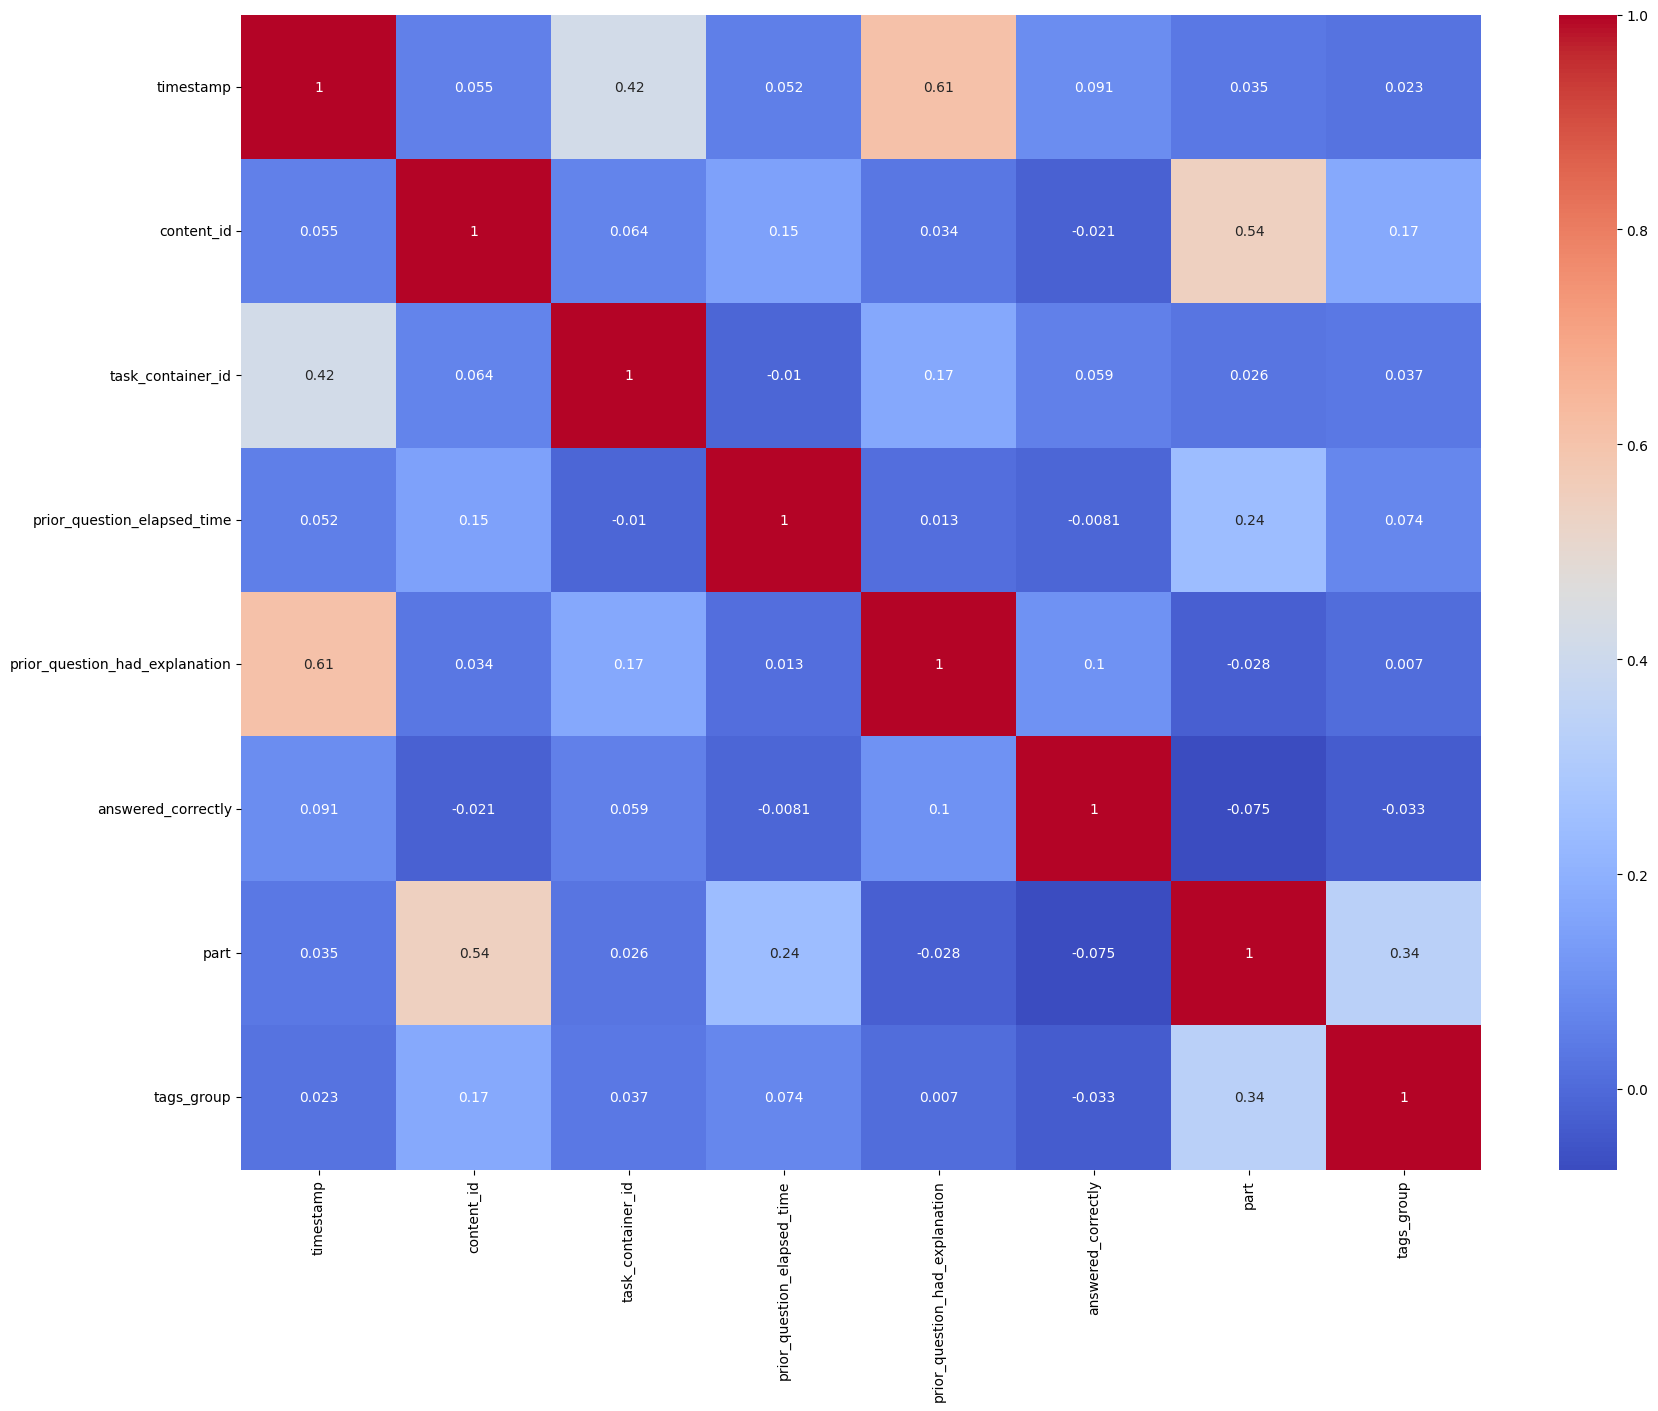

In [88]:
# Посмотрим на матрицу еще раз
correlation_matrix = data.corr()
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes)
plt.show()

#### Итоговый вывод по EDA:
Все еще есть подозрение на мультиколлинеарность, как вариант использовать PCA на timestamp и prior_question_had explanation, а так же на content_id и part.

Так же видно как пострадала корреляция на таргет без утечек со стороны правильного_ответа + ответа_данного пользователем, как уже было отмечено, я считаю не корректным использовать в модели предсказания правильности ответа, данные которые содержат в себе эту "правильность", иначе для выбивания метрики мы могли бы не изголяться а сверять два фита и давать предикт если они совпадают.


---